## Tutorial notebook

This Jupyter notebook shows how to perform a basic analysis of γ-ray photon-count maps using the convolutional neural network-based method presented in [arXiv:2107.09070](http://arxiv.org/abs/2107.09070). 

In this example, the photon-count maps consist of **three** different emission components:    
1. *Fermi* bubbles (Poissonian)
2. Galactic Center Excess (point source-like, single population)
3. Isotropic point sources (point source-like, two populations in each map).

As discussed in the paper, for the point source-like templates the Poissonian case is included as the limit of ultra-faint point source emission (<< 1 photon expected per source) where the neural network can no longer distinguish point sources from Poissonian emission.

To consider different scenarios (e.g. other templates, more training data, different network architectures, etc.), simply modify the sample parameter file ```GCE_NN/parameter_files/parameters.py``` accordingly.
The available templates can be viewed in the function ```get_templates()``` in ```GCE/data_utils.py```.

Also, if you don't have access to a GPU and just want to try out the code, it is recommended to reduce the number of training steps in the ```parameters.py```
file in the folder ```parameter_files``` under "Training settings" from ```2500``` to e.g. ```p_train['num_steps'] = 500``` to reduce the
training time. In this case, you will see a warning
```
"WARNING:tensorflow:There are non-GPU devices in `tf.distribute.Strategy`...
```

In [1]:
import ray
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
import os

In [2]:
%pip list | grep gce-nn   # check if gce-nn module is there
import GCE.gce

gce-nn                  0.0.1
Note: you may need to restart the kernel to use updated packages.


2022-04-06 11:07:55.089467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 11:07:55.089506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First, we need to **initialize** an analysis object.

In [3]:
gce = GCE.gce.Analysis()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


2022-04-06 11:07:57.301701: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 11:07:57.307684: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-06 11:07:57.457696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-06 11:07:57.457731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
202

Now, let's **load the parameters** from the parameter file in the parameter_files folder.

In [4]:
gce.load_params("../parameter_files/parameters.py")

Loading parameters from '../parameter_files/parameters.py'...
Loading parameters: ['comb' 'data' 'gen' 'mod' 'nn' 'plot' 'train' 'tt']


/home/flo/GCE_NN/GCE/gce.py:272: RuntimeWarning: invalid value encountered in log10
  bin_edges_mapped = np.log10(bin_edges) if self.p.nn.hist["log_spaced_bins"] else bin_edges


We can take a look at the loaded parameters:

In [5]:
gce.print_params()

{'comb': {'N_test': 2,
          'N_val': 2,
          'bins_counts_per_PS': array([-0.5,  2.5,  5.5,  8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5,
       32.5, 35.5, 38.5, 41.5, 44.5, 47.5, 50.5, 53.5, 56.5, 59.5,  inf]),
          'bins_counts_per_pix': array([-0.5,  2.5,  5.5,  8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5,
       32.5, 35.5, 38.5, 41.5, 44.5, 47.5, 50.5, 53.5, 56.5, 59.5,  inf]),
          'bins_dNdF': array([          -inf, 3.16227766e-13, 5.95662144e-13, 1.12201845e-12,
       2.11348904e-12, 3.98107171e-12, 7.49894209e-12, 1.41253754e-11,
       2.66072506e-11, 5.01187234e-11, 9.44060876e-11, 1.77827941e-10,
       3.34965439e-10, 6.30957344e-10, 1.18850223e-09, 2.23872114e-09,
       4.21696503e-09, 7.94328235e-09, 1.49623566e-08, 2.81838293e-08,
       5.30884444e-08, 1.00000000e-07,            inf]),
          'combine_without_PSF': False,
          'data_name': 'Example_comb',
          'do_counts_per_PS': False,
          'do_counts_per_pix': False,
     

The parameters are stored in gce.p and can also be accessed group-wise. For example, the Poissonian (P) and point-source (PS) templates used in this analysis can be viewed with

In [6]:
gce.p.mod

{'models_P': ['bub'],
 'models_PS': ['gce_12_PS', 'iso_PS'],
 'model_names_P': ['$\\it{Fermi}$ bubbles'],
 'model_names_PS': ['GCE', 'isotropic PS'],
 'models': ['bub', 'gce_12_PS', 'iso_PS'],
 'model_names': ['$\\it{Fermi}$ bubbles', 'GCE', 'isotropic PS'],
 'n_models_P': 1,
 'n_models_PS': 2,
 'n_models': 3}

and the data-related settings (such as the exposure map, the mask for the region of interest, as well as whether the *Fermi* point-spread function at 2 GeV shall be applied) are stored in

In [7]:
gce.p.data

{'outer_rad': 25.0,
 'inner_band': 2.0,
 'leakage_delta': 0.75,
 'mask_type': '3FGL',
 'nside': 128,
 'exposure': 'Fermi',
 'psf': True,
 'Ebins': array([ 0.1,  0.2,  0.3,  0.5,  0.8,  1.5, 10. ]),
 'npix': 196608}

Now, let's generate some simulated Monte Carlo photon-count maps for each of the templates. The relevant parameters are stored in the field "tt" (training and testing data) - most importantly the priors, as well as the number of maps given by "n_chunk" (each chunk will be saved in a single file) times the number of simulations per chunk.

In [8]:
gce.p.tt

{'data_name': 'Example',
 'filename_base': 'Maps',
 'poisson_A_is_log': False,
 'n_chunk': 100,
 'n_sim_per_chunk': 50,
 'add_two_temps_PS': ['iso_PS'],
 'priors': {'bub': array([0., 2.]),
  'gce_12_PS': {'mean_exp': [-12, -9],
   'var_exp': 0.25,
   'skew_std': 3.0,
   'flux_lims': [0, 1.4e-08],
   'flux_log': False,
   'enforce_upper_flux': True},
  'iso_PS': {'mean_exp': [-12, -9],
   'var_exp': 0.25,
   'skew_std': 3.0,
   'flux_lims': [0, 1.4e-08],
   'flux_log': False,
   'enforce_upper_flux': True}}}

To **generate** the template maps, we can simply run

In [9]:
# Ray settings (for parallelized data generation)
import ray
ray.shutdown() #delete old rays if there are any
# ray_settings = {"num_cpus": 4, "object_store_memory": 2000000000}
ray_settings = {"num_cpus": 4}  # select the number of CPUs here
gce.generate_template_maps(ray_settings, n_example_plots=5, job_id=0)

Job ID: 0 Random Seed: 3062671110
Starting map generation for 'Example'.
Number of chunks: 100, number of simulations per chunk: 50
 -> 5000 maps per model.
 Twice as many maps will be created for ['iso_PS']
Starting with Poissonian model 'bub'
   Writing settings file...
Ray: running on 4 CPUs.
Starting with point-source model 'gce_12_PS'
  Starting with chunk 0


/home/flo/GCE_NN/GCE/data_generation.py:280: UserWarning: Template sum is not exactly 1, but 0.9999999999999998!
  warnings.warn("Template sum is not exactly 1, but {:}!".format(t_final.sum()))


   Writing settings file...
  Starting with chunk 1
  Starting with chunk 2
  Starting with chunk 3
  Starting with chunk 4
  Starting with chunk 5
  Starting with chunk 6
  Starting with chunk 7
  Starting with chunk 8
  Starting with chunk 9
  Starting with chunk 10
  Starting with chunk 11
  Starting with chunk 12
  Starting with chunk 13
  Starting with chunk 14
  Starting with chunk 15
  Starting with chunk 16
  Starting with chunk 17
  Starting with chunk 18
  Starting with chunk 19
  Starting with chunk 20
  Starting with chunk 21
  Starting with chunk 22
  Starting with chunk 23
  Starting with chunk 24
  Starting with chunk 25
  Starting with chunk 26
  Starting with chunk 27
  Starting with chunk 28
  Starting with chunk 29
  Starting with chunk 30
  Starting with chunk 31
  Starting with chunk 32
  Starting with chunk 33
  Starting with chunk 34
  Starting with chunk 35
  Starting with chunk 36
  Starting with chunk 37
  Starting with chunk 38
  Starting with chunk 39
  Star

/home/flo/GCE_NN/GCE/data_generation.py:280: UserWarning: Template sum is not exactly 1, but 0.9999999999999998!
  warnings.warn("Template sum is not exactly 1, but {:}!".format(t_final.sum()))


   Writing settings file...
  Starting with chunk 1
  Starting with chunk 2
  Starting with chunk 3
  Starting with chunk 4
  Starting with chunk 5
  Starting with chunk 6
  Starting with chunk 7
  Starting with chunk 8
  Starting with chunk 9
  Starting with chunk 10
  Starting with chunk 11
  Starting with chunk 12
  Starting with chunk 13
  Starting with chunk 14
  Starting with chunk 15
  Starting with chunk 16
  Starting with chunk 17
  Starting with chunk 18
  Starting with chunk 19
  Starting with chunk 20
  Starting with chunk 21
  Starting with chunk 22
  Starting with chunk 23
  Starting with chunk 24
  Starting with chunk 25
  Starting with chunk 26
  Starting with chunk 27
  Starting with chunk 28
  Starting with chunk 29
  Starting with chunk 30
  Starting with chunk 31
  Starting with chunk 32
  Starting with chunk 33
  Starting with chunk 34
  Starting with chunk 35
  Starting with chunk 36
  Starting with chunk 37
  Starting with chunk 38
  Starting with chunk 39
  Star

In [10]:
import pickle
#check the shape
maps=open('/home/flo/GCE_NN/data/Template_maps/Example_128/bub/Maps_0_3.pickle','rb')
test=pickle.load(maps)
type(test)
data=test["data"]
type(data)
print(data.shape)
print(test.keys())

(50, 7749, 6)
dict_keys(['data', 'info'])


Some example maps (whose number is determined by ```n_example_plots``` above) for each template can be viewed in the folder ```GCE_NN/data/Template_maps/Example_128```.

The next step is to **combine** (i.e. sum up) the individual template maps to obtain the final training, validation, and testing maps. Internally, this is done in two steps: 1) the filenames of the template maps for each of these three subsets are stored in a file, and 2) the template maps are combined and saved.

In [11]:
gce.combine_template_maps(save_filenames=True, do_combine=True)

Filenames for training saved.
Filenames for validation saved.
Filenames for testing saved.
Settings file saved.
EXITING.
Combined settings file written.
Done! Computation took 1.3e+01 seconds.


In [12]:
import pickle
#check the shape
maps=open('/home/flo/GCE_NN/data/Combined_maps/Example_comb_128/Train/Maps_07_train.pickle','rb')
test=pickle.load(maps)
type(test)
data=test["data"]
type(data)
print(data.shape)
print(test.keys())

(50, 7749, 6)
dict_keys(['data', 'flux_fraction', 'info', 'hists'])


In [13]:
(test["flux_fraction"]['iso_PS']).shape

(50, 6)

NOTE: if data has already been generated, the corresponding parameters can be directly loaded from the template maps / combined maps folders, e.g.

```
gce.load_params("../data/Template_maps/Test_128")
gce.load_params("../data/Combined_maps/Test_comb_128")
```


Next, we need to build the **data processing pipeline** that will feed the combined photon-count maps to the neural network.

In [14]:
gce.build_pipeline()

(7749, 1)
(7749, 1)
(7749, 1)
Input pipeline successfully built.


2022-04-06 11:15:46.889733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-06 11:15:46.896184: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496005000 Hz


We can use the method ```get_samples()``` to get photon-count maps and their associated labels from the datasets **train** (used for training), **val** (used as an independent validation dataset during training), and **test** (used for testing once the training is finished) 

In [15]:

samples = gce.datasets["test"].get_samples(1)
data, labels = samples["data"], samples["label"]  # samples contains data and labels (flux fractions & SCD histograms)
print("Shapes:")
print("  Flux fractions", labels[0].shape)  # n_samples x n_templates
print("  SCD histograms", labels[1].shape)  # n_samples x n_bins x n_PS_templates

Shapes:
  Flux fractions (1, 3, 6)
  SCD histograms (1, 22, 2)


Let's take a look at a combined map. The maps are compressed and only contain the pixels that lie within the ROI - the method ```decompress()``` returns the full-sky map that can be fed to the healpy functions.

We will plot 
1. the **photon-count map**, 
2. the rescaled version in **'flux' space** as shown to the neural network (divided by exposure correction), and 
3. the *Fermi* **exposure correction**.

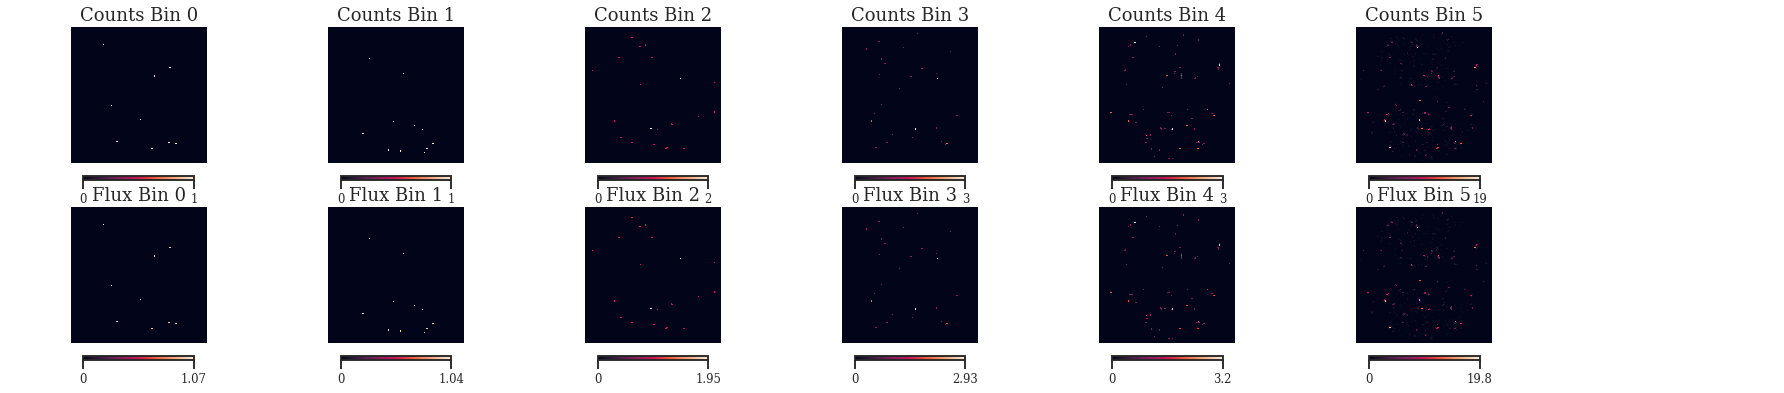

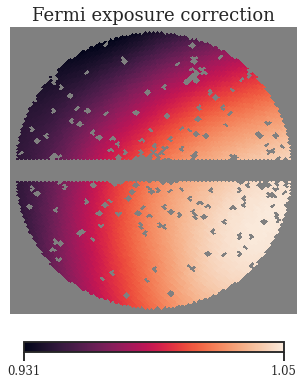

In [16]:
# NOTE: the maps are stored in NEST format
map_to_plot = 0 #index of which map is plotted
r = gce.p.data["outer_rad"] + 1
fig, ax= plt.subplots(2,7,figsize = (25,5))

subplot=1
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()
for Ebin in range(0,6):

    hp.cartview(gce.decompress(data[map_to_plot,:,Ebin] * gce.template_dict["rescale_compressed"]), nest=True,
                 lonra=[-r, r], latra=[-r, r], sub=(2,7,subplot), title='Counts Bin ' + str(Ebin))

    hp.cartview(gce.decompress(data[map_to_plot,:,Ebin]), nest=True,
                 lonra=[-r, r], latra=[-r, r], sub=(2,7,7+subplot), title='Flux Bin ' + str(Ebin))
    subplot+=1

plt.show()


hp.cartview(gce.decompress(gce.template_dict["rescale_compressed"], fill_value=np.nan), nest=True,
                title="Fermi exposure correction", lonra=[-r, r], latra=[-r, r])
plt.show()


Let's also plot the real *Fermi* map in our region of interest. Of course, it looks quite different from our simulated maps because we only included the *Fermi* bubbles, the GCE, and isotropic point sources in this example (so we are completely ignoring the diffuse Galactic foregrounds, which are responsible for the majority of photon counts).

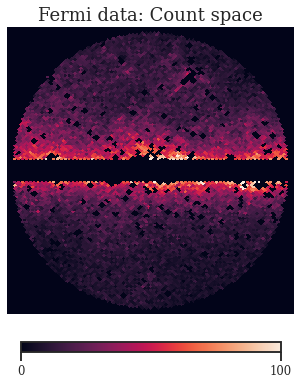

In [17]:
fermi_counts = gce.datasets["test"].get_fermi_counts()
hp.cartview(gce.decompress(fermi_counts * gce.generators["test"].settings_dict["rescale_compressed"]), nest=True,
            title="Fermi data: Count space", max=100, lonra=[-r, r], latra=[-r, r])
# hp.cartview(gce.decompress(fermi_counts), nest=True, title="Fermi data: Flux space", max=100)
plt.show()

Now, it's time to **build** our neural network:


In [18]:
gce.build_nn()

(7749, 6)
KerasTensor(type_spec=TensorSpec(shape=(None, 7749, 6), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
(None, 7749, 6)
Input shape = 3
first channel
KerasTensor(type_spec=TensorSpec(shape=(None, 7749, 6), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), name='tf.math.reduce_sum_1/Sum:0', description="created by layer 'tf.math.reduce_sum_1'")
first channel
(None, 7749, 6)
laplacian
t shape b4 pool
(None, 7749, 32)
t shape after pool
(None, 2140, 32)
laplacian
t shape b4 pool
(None, 2140, 64)
t shape after pool
(None, 589, 64)
laplacian
t shape b4 pool
(None, 589, 128)
t shape after pool
(None, 163, 128)
laplacian
t shape b4 pool
(None, 163, 256)
t shape after pool
(None, 50, 256)
laplacian
t shape b4 pool
(None, 50, 256)
t shape after pool
(None, 14, 256)
laplacian
t shape b4 pool
(None, 14, 256)
t shape af

*NOTE*: Once the neural network has been trained, **loading** is as easy as ```gce.load_nn()```.

In [19]:
#gce.load_nn()

    Let's **train** our neural network to predict
1. the **flux fractions** of the different templates (using a negative maximum log-likelihood loss function), and 
2. the **SCD histograms** of the GCE and isotropic point source populations (using the *Earth Mover's pinball loss*, see [arXiv:2106.02051](https://arxiv.org/abs/2106.02051)).

In [20]:
gce.train_nn("flux_fractions")

Training flux fractions from scratch.
19 tensor(s) will be trained.
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')

=== STARTING TRAINING ===


  0%|          | 0/2500 [00:00<?, ?it/s]

Validation: End of epoch!
Validation: End of epoch!


 10%|█         | 250/2500 [03:26<26:31,  1.41it/s, train_loss=-25.2]

Validation: End of epoch!


 11%|█▏        | 287/2500 [03:54<26:55,  1.37it/s, train_loss=-25.3]

Training: End of epoch!


 23%|██▎       | 587/2500 [07:40<23:51,  1.34it/s, train_loss=-28.1]

Training: End of epoch!


 24%|██▍       | 600/2500 [07:49<24:36,  1.29it/s, train_loss=-30.6]

Validation: End of epoch!


 35%|███▌      | 887/2500 [11:23<18:50,  1.43it/s, train_loss=-29.9]

Training: End of epoch!


 36%|███▌      | 900/2500 [11:32<18:13,  1.46it/s, train_loss=-33]  

Validation: End of epoch!


 47%|████▋     | 1187/2500 [14:51<14:25,  1.52it/s, train_loss=-30]  

Training: End of epoch!


 48%|████▊     | 1200/2500 [15:00<15:05,  1.43it/s, train_loss=-33.8]

Validation: End of epoch!


 59%|█████▉    | 1487/2500 [18:32<13:26,  1.26it/s, train_loss=-30.5]

Training: End of epoch!


 60%|██████    | 1500/2500 [18:41<11:37,  1.43it/s, train_loss=-33.6]

Validation: End of epoch!


 71%|███████▏  | 1787/2500 [22:13<08:29,  1.40it/s, train_loss=-30.7]

Training: End of epoch!


 74%|███████▍  | 1850/2500 [23:00<07:41,  1.41it/s, train_loss=-37.2]

Validation: End of epoch!


 83%|████████▎ | 2087/2500 [25:57<04:51,  1.42it/s, train_loss=-31.5]

Training: End of epoch!


 86%|████████▌ | 2150/2500 [26:43<04:12,  1.39it/s, train_loss=-37.7]

Validation: End of epoch!


 95%|█████████▌| 2387/2500 [29:46<01:24,  1.34it/s, train_loss=-32]  

Training: End of epoch!


 98%|█████████▊| 2450/2500 [30:33<00:35,  1.39it/s, train_loss=-37.9]

Validation: End of epoch!


100%|██████████| 2500/2500 [31:10<00:00,  1.34it/s, train_loss=-32.9]

=== TRAINING FINISHED ===



In [21]:
#gce.train_nn("histograms")

Finally, let's **evaluate** the performance of our neural network on simulated test data.

In [22]:
n_samples = 20
test_samples = gce.datasets["test"].get_samples(n_samples)
test_data, test_ffs, test_hists = test_samples["data"], test_samples["label"][0], test_samples["label"][1]
tau = np.arange(5, 100, 5) * 0.01  # quantile levels for SCD histograms, from 5% to 95% in steps of 5%
pred = gce.predict(test_data, tau=tau, multiple_taus=True)  # get the NN predictions

ValueError: Layer model expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(20, 7749, 6), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.98244375],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         3.9845853 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         2.1092653 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         2.1293998 ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         1.9648875 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.9961463 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.99250174],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         2.1092653 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         1.051352  ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         1.0646999 ]],

       [[0.        , 0.        , 0.        , 0.98244375, 0.        ,
         0.98244375],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.9961463 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         3.970007  ],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         2.1092653 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         2.1293998 ]],

       ...,

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.98244375],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.9961463 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         3.970007  ],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         2.1092653 ],
        [1.051352  , 0.        , 0.        , 0.        , 1.051352  ,
         2.102704  ],
        [0.        , 0.        , 0.        , 0.        , 1.0646999 ,
         2.1293998 ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         1.051352  ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]]], dtype=float32)>, <tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05]])>]

In [23]:
# Make some plots (will be saved in the models folder)
gce.plot_nn_architecture()
gce.plot_flux_fractions_Ebin(test_ffs, pred)
gce.plot_flux_fractions_total(test_ffs, pred)
#gce.plot_histograms(test_hists, pred, plot_inds=np.arange(9))
gce.plot_maps(test_data, decompress=True, plot_inds=np.arange(9))
plt.show()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


AttributeError: 'Analysis' object has no attribute 'plot_flux_fractions_Ebin'

Clearly, the training dataset is too small and the training was too short to obtain accurate and precise predictions. Still, the neural networks have already learned *something*, and the predictions are roughly in the right ballpark.